In [1]:
# Assuming that the fridom package is in the parent directory
# If fridom is installed, the next two lines are not needed
import sys, os
sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt

from fridom.Framework.ModelSettingsBase import ModelSettingsBase
from fridom.Framework.ModelBase import ModelBase
from fridom.Framework.BoundaryConditions import BoundaryConditions, Periodic
from fridom.Framework.GridBase import GridBase
from fridom.Framework.StateBase import StateBase
from fridom.Framework.FieldVariable import FieldVariable

In [2]:
class ModelSettings(ModelSettingsBase):
    def __init__(self, **kwargs):
        self.g = 9.81
        self.H = 4
        super().__init__(n_dims=2, **kwargs)

class Grid(GridBase):
    def __init__(self, mset):
        super().__init__(mset)

class State(StateBase):
    def __init__(self, mset, grid, field_list=None, **kwargs):
        if field_list is None:
            bc = BoundaryConditions([Periodic(mset,-1), Periodic(mset,1)])
            field_list = [
                FieldVariable(mset, grid, name="Velocity: u", bc=bc),
                FieldVariable(mset, grid, name="Velocity: v", bc=bc),
                FieldVariable(mset, grid, name="Height: h", bc=bc)
            ]
        super().__init__(mset, grid, field_list)
        self.constructor = State

    @property
    def u(self): return self.field_list[0]
    @u.setter
    def u(self, value): self.field_list[0] = value
    @property
    def v(self): return self.field_list[1]
    @v.setter
    def v(self, value): self.field_list[1] = value
    @property
    def h(self): return self.field_list[2]
    @h.setter
    def h(self, value): self.field_list[2] = value
    

class Model(ModelBase):
    def __init__(self, mset, grid):
        super().__init__(mset, grid, State)

    def total_tendency(self):
        z = self.z;      dz = self.dz
        g = self.mset.g;  H = self.mset.H
        dz.u[:] = g * z.h.diff_forward(0)
        dz.v[:] = g * z.h.diff_forward(1)
        dz.h[:] = H * (z.u.diff_backward(0) + z.v.diff_backward(1))

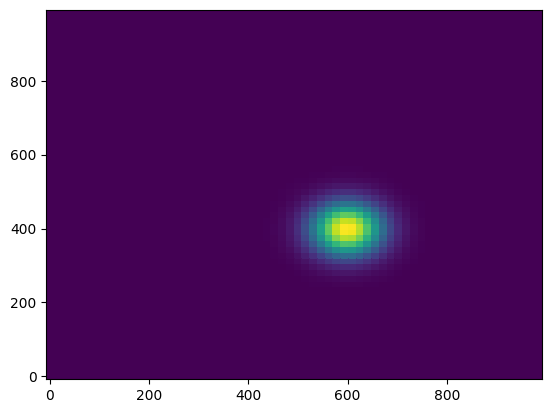

In [3]:
mset = ModelSettings(gpu=False, L=[1000,1000], g=1, H=1, dt=1)
grid = Grid(mset)
X, Y = grid.X
z_ini = State(mset, grid)
h_ini = z_ini.cp.exp(-((X-600)**2 + (Y-400)**2)/70**2)
z_ini.h[:] = h_ini

plt.pcolor(X, Y, z_ini.field_list[2])

100%|██████████| 300/300 [00:00<00:00, 1886.74it/s]


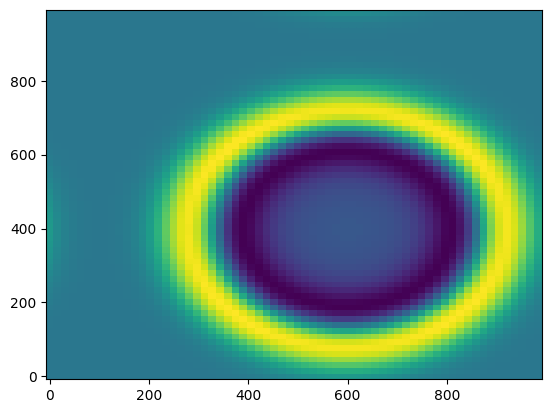

In [4]:
model = Model(mset, grid)
model.z = z_ini
model.z
model.run(runlen=300)

plt.pcolor(X, Y, model.z.h)